In [1]:
'''''''''''''''''''''''''''
DATA CLEANING
FEATURE ENGINEERING
API READING
ETC
'''''''''''''''''''''''''''
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
df_crop = pd.read_csv(r"C:\ML DataSets\Agriculture_DataSets\Crop_recommendation.csv")

In [2]:
url = "https://power.larc.nasa.gov/api/temporal/daily/point"

params = {
    "parameters": "ALLSKY_SFC_SW_DWN,WS10M",  
    "community": "ag",
    "longitude": 78.0,
    "latitude": 20.0,   
    "start": "20170101",  
    "end": "20231231",    
    "format": "JSON"
}

response = requests.get(url, params=params)
data = response.json()

radiation = data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]
wind_speed = data["properties"]["parameter"]["WS10M"]

df_climate = pd.DataFrame({
    "Solar_Radiation (kWh/m²)": radiation.values(),
    "Wind_Speed (m/s)": wind_speed.values()
})

weights = np.linspace(0.5, 1.0, len(df_climate))

avg_solar_radiation = np.average(df_climate["Solar_Radiation (kWh/m²)"], weights=weights)
avg_wind_speed = np.average(df_climate["Wind_Speed (m/s)"], weights=weights)

np.random.seed(42)
df_crop["Solar_Radiation (kWh/m²)"] = np.random.normal(avg_solar_radiation, 0.1, len(df_crop))
df_crop["Wind_Speed (m/s)"] = np.random.normal(avg_wind_speed, 0.1, len(df_crop))

In [5]:
df = df_crop

In [6]:
df.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label,Solar_Radiation (kWh/m²),Wind_Speed (m/s)
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,17.963890,3.390431
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,17.900392,3.190906
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,17.978987,3.281972
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,18.066522,3.080669
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,17.890803,3.114353
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice,17.890805,3.257237
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice,18.072140,3.358408
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice,17.990962,3.245558
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice,17.867271,3.178691
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice,17.968475,3.209926


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N                         2200 non-null   int64  
 1   P                         2200 non-null   int64  
 2   K                         2200 non-null   int64  
 3   temperature               2200 non-null   float64
 4   humidity                  2200 non-null   float64
 5   ph                        2200 non-null   float64
 6   rainfall                  2200 non-null   float64
 7   label                     2200 non-null   object 
 8   Solar_Radiation (kWh/m²)  2200 non-null   float64
 9   Wind_Speed (m/s)          2200 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 172.0+ KB


In [8]:
df.isna().sum()

N                           0
P                           0
K                           0
temperature                 0
humidity                    0
ph                          0
rainfall                    0
label                       0
Solar_Radiation (kWh/m²)    0
Wind_Speed (m/s)            0
dtype: int64

In [9]:
df['NPK_Ratio'] = np.where((df['P'] + df['K']) != 0, df['N'] / (df['P'] + df['K']), 0)

In [10]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label,Solar_Radiation (kWh/m²),Wind_Speed (m/s),NPK_Ratio
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,17.963890,3.390431,1.058824
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,17.900392,3.190906,0.858586
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,17.978987,3.281972,0.606061
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,18.066522,3.080669,0.986667
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,17.890803,3.114353,0.928571


In [11]:
def soil_quality(npk_ratio, pH):
    if npk_ratio < 0.5 or pH < 5.5 or pH > 8.5:
        return 0
    elif 0.5 <= npk_ratio <= 0.8 or 5.5 <= pH < 6.0 or 7.5 <= pH <= 8.5:
        return 1
    elif 0.8 < npk_ratio <= 1.2 or 6.0 <= pH < 6.5 or 7.0 <= pH <= 7.5:
        return 2
    else:
        return 3

In [12]:
df['Soil_Quality'] = df.apply(lambda row: soil_quality(row['NPK_Ratio'], row['ph']), axis=1)

In [13]:
print(df['label'].unique())

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [14]:
y_max_values = {
    'rice': 10,
    'maize': 15,
    'chickpea': 3,
    'kidneybeans': 2,
    'pigeonpeas': 2,
    'mothbeans': 1,
    'mungbean': 2,
    'blackgram': 2,
    'lentil': 3,
    'pomegranate': 15,
    'banana': 50,
    'mango': 15,
    'grapes': 15,
    'watermelon': 40,
    'muskmelon': 35,
    'apple': 50,
    'orange': 30,
    'papaya': 50,
    'coconut': 10,
    'cotton': 3.5,
    'jute': 3,
    'coffee': 4
}


df['Y_Max'] = df['label'].map(y_max_values)

In [15]:
df.to_csv("crop_yield_data.csv", index=False)
import shutil
shutil.move("crop_yield_data.csv", r"C:\ML_Projects\Crop_Yield") 

'C:\\ML_Projects\\Crop_Yield'

    N   P   K  temperature   humidity        ph    rainfall  Crop_Yield
0  90  42  43    20.879744  82.002744  6.502985  202.935536   22.813413
1  85  58  41    21.770462  80.319644  7.038096  226.655537   22.283663
2  60  55  44    23.004459  82.320763  7.840207  263.964248   20.742700
3  74  35  40    26.491096  80.158363  6.980401  242.864034   22.732378
4  78  42  42    20.130175  81.604873  7.628473  262.717340   20.844252


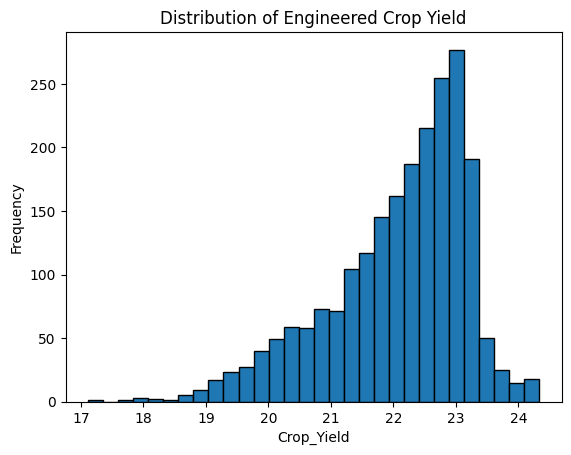

In [16]:
soil_quality_map = {
    'Excellent': 1.0,
    'Good': 0.8,
    'Moderate': 0.5,
    'Poor': 0.2
}
df['Soil_Quality Numerical'] = df['Soil_Quality'].map(soil_quality_map)

params = {
    "Y_max": 10.0,    
    "w_N": 0.3,
    "w_P": 0.3,
    "w_K": 0.3,
    "w_rain": 0.4,
    "w_temp": 0.2,
    "w_ph": 0.3,
    "w_humid": 0.1,
    "alpha_N": 1.0,
    "alpha_P": 1.0,
    "alpha_K": 1.0,
    "alpha_r": 1.2,      
    "ph_mu": 6.5,       
    "ph_sigma": 0.8     
}
def saturate(x, alpha):
    #x^alpha / (1 + x^alpha)
    return np.where(x > 0, x**alpha / (1 + x**alpha), 0)

def yield_formula(row, p):
    N = row["N"]
    P = row["P"]
    K = row["K"]
    temp = max(0, row["temperature"])   
    hum = row["humidity"]
    ph_val = row["ph"]
    rain = row["rainfall"]
    
 
    N_part = saturate(N, p["alpha_N"])
    P_part = saturate(P, p["alpha_P"])
    K_part = saturate(K, p["alpha_K"])
    rain_part = saturate(rain, p["alpha_r"])
    
    #log(1 + temp)
    temp_part = np.log(1 + temp)
    
    #Gaussian peaked at ph_mu
    ph_part = np.exp(-((ph_val - p["ph_mu"])**2) / (2 * p["ph_sigma"]**2))
    
    #(hum/100)
    hum_part = hum / 100.0
    
    combined = (p["w_N"] * N_part +
                p["w_P"] * P_part +
                p["w_K"] * K_part +
                p["w_rain"] * rain_part +
                p["w_temp"] * temp_part +
                p["w_ph"] * ph_part +
                p["w_humid"] * hum_part)
    
    # Scale by Y_max
    return p["Y_max"] * combined

df = df.copy()  

df["Crop_Yield"] = df.apply(lambda row: yield_formula(row, params), axis=1)

df["Crop_Yield"] = df["Crop_Yield"].clip(upper=50)

print(df[["N", "P", "K", "temperature", "humidity", "ph", "rainfall", "Crop_Yield"]].head())

import matplotlib.pyplot as plt
plt.hist(df["Crop_Yield"], bins=30, edgecolor="k")
plt.xlabel("Crop_Yield")
plt.ylabel("Frequency")
plt.title("Distribution of Engineered Crop Yield")
plt.show()

In [17]:
df.head(100)

,N,P,K,temperature,humidity,ph,rainfall,label,Solar_Radiation (kWh/m²),Wind_Speed (m/s),NPK_Ratio,Soil_Quality,Y_Max,Soil_Quality Numerical,Crop_Yield
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,17.963890,3.390431,1.058824,2,10.0,NaN,22.813413
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,17.900392,3.190906,0.858586,2,10.0,NaN,22.283663
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,17.978987,3.281972,0.606061,1,10.0,NaN,20.742700
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,18.066522,3.080669,0.986667,2,10.0,NaN,22.732378
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,17.890803,3.114353,0.928571,1,10.0,NaN,20.844252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,88,46,42,22.683191,83.463583,6.604993,194.265172,rice,17.767867,3.262248,1.000000,2,10.0,NaN,22.963971
96,93,47,37,21.533463,82.140041,6.500343,295.924880,rice,17.943831,3.251836,1.107143,2,10.0,NaN,22.873714
97,60,55,45,21.408658,83.329319,5.935745,287.576694,rice,17.940324,3.350156,0.600000,1,10.0,NaN,22.219096
98,78,35,44,26.543481,84.673536,7.072656,183.622266,rice,17.914730,3.275042,0.987342,2,10.0,NaN,22.604592


In [18]:
df.isna().sum()

N                              0
P                              0
K                              0
temperature                    0
humidity                       0
ph                             0
rainfall                       0
label                          0
Solar_Radiation (kWh/m²)       0
Wind_Speed (m/s)               0
NPK_Ratio                      0
Soil_Quality                   0
Y_Max                          0
Soil_Quality Numerical      2200
Crop_Yield                     0
dtype: int64

In [19]:
df.to_csv("crop_yield_data.csv", index=False)
import shutil
shutil.move("crop_yield_data.csv", r"C:\ML_Projects\Crop_Yield") 

'C:\\ML_Projects\\Crop_Yield'

In [20]:
new_column_order = ['N', 'P', 'K', 'temperature' ,'humidity', 'ph','NPK_Ratio','rainfall', 'Wind_Speed (m/s)', 'Solar_Radiation (kWh/m²)', 'label', 'Y_Max' ,'Soil_Quality', 'Crop_Yield']

df = df[new_column_order]

df.head()

,N,P,K,temperature,humidity,ph,NPK_Ratio,rainfall,Wind_Speed (m/s),Solar_Radiation (kWh/m²),label,Y_Max,Soil_Quality,Crop_Yield
0,90,42,43,20.879744,82.002744,6.502985,1.058824,202.935536,3.390431,17.963890,rice,10.0,2,22.813413
1,85,58,41,21.770462,80.319644,7.038096,0.858586,226.655537,3.190906,17.900392,rice,10.0,2,22.283663
2,60,55,44,23.004459,82.320763,7.840207,0.606061,263.964248,3.281972,17.978987,rice,10.0,1,20.742700
3,74,35,40,26.491096,80.158363,6.980401,0.986667,242.864034,3.080669,18.066522,rice,10.0,2,22.732378
4,78,42,42,20.130175,81.604873,7.628473,0.928571,262.717340,3.114353,17.890803,rice,10.0,1,20.844252


In [21]:
df = df.rename(columns = {'label':'Crop Variety Category'})
df

,N,P,K,temperature,humidity,ph,NPK_Ratio,rainfall,Wind_Speed (m/s),Solar_Radiation (kWh/m²),Crop Variety Category,Y_Max,Soil_Quality,Crop_Yield
0,90,42,43,20.879744,82.002744,6.502985,1.058824,202.935536,3.390431,17.963890,rice,10.0,2,22.813413
1,85,58,41,21.770462,80.319644,7.038096,0.858586,226.655537,3.190906,17.900392,rice,10.0,2,22.283663
2,60,55,44,23.004459,82.320763,7.840207,0.606061,263.964248,3.281972,17.978987,rice,10.0,1,20.742700
3,74,35,40,26.491096,80.158363,6.980401,0.986667,242.864034,3.080669,18.066522,rice,10.0,2,22.732378
4,78,42,42,20.130175,81.604873,7.628473,0.928571,262.717340,3.114353,17.890803,rice,10.0,1,20.844252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,1.621212,177.774507,3.074245,17.848020,coffee,4.0,3,22.921695
2196,99,15,27,27.417112,56.636362,6.086922,2.357143,127.924610,3.119929,17.956807,coffee,4.0,2,22.549478
2197,118,33,30,24.131797,67.225123,6.362608,1.873016,173.322839,3.113577,17.916133,coffee,4.0,2,22.858168
2198,117,32,34,26.272418,52.127394,6.758793,1.772727,127.175293,3.318002,17.850070,coffee,4.0,3,22.766147


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N                         2200 non-null   int64  
 1   P                         2200 non-null   int64  
 2   K                         2200 non-null   int64  
 3   temperature               2200 non-null   float64
 4   humidity                  2200 non-null   float64
 5   ph                        2200 non-null   float64
 6   NPK_Ratio                 2200 non-null   float64
 7   rainfall                  2200 non-null   float64
 8   Wind_Speed (m/s)          2200 non-null   float64
 9   Solar_Radiation (kWh/m²)  2200 non-null   float64
 10  Crop Variety Category     2200 non-null   object 
 11  Y_Max                     2200 non-null   float64
 12  Soil_Quality              2200 non-null   int64  
 13  Crop_Yield                2200 non-null   float64
dtypes: float

In [23]:
df.to_csv("Agriculture_Cleaned_Data.csv", index=False) 
shutil.move("Agriculture_Cleaned_Data.csv", r'C:\ML DataSets\Agriculture_DataSets\Agriculture_Cleaned_Data.csv') 

'C:\\ML DataSets\\Agriculture_DataSets\\Agriculture_Cleaned_Data.csv'

In [24]:
'''''''''''''''
CREATING MODEL
USING
NEURAL NETWORKS
'''''''''''''''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
import tensorflow.keras.backend as K
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import numpy as np
import collections

In [25]:
df = pd.read_csv(r"C:\ML DataSets\Agriculture_DataSets\Agriculture_Cleaned_Data.csv")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   N                         2200 non-null   int64  
 1   P                         2200 non-null   int64  
 2   K                         2200 non-null   int64  
 3   temperature               2200 non-null   float64
 4   humidity                  2200 non-null   float64
 5   ph                        2200 non-null   float64
 6   NPK_Ratio                 2200 non-null   float64
 7   rainfall                  2200 non-null   float64
 8   Wind_Speed (m/s)          2200 non-null   float64
 9   Solar_Radiation (kWh/m²)  2200 non-null   float64
 10  Crop Variety Category     2200 non-null   object 
 11  Y_Max                     2200 non-null   float64
 12  Soil_Quality              2200 non-null   int64  
 13  Crop_Yield                2200 non-null   float64
dtypes: float

In [27]:
df.describe()

,N,P,K,temperature,humidity,ph,NPK_Ratio,rainfall,Wind_Speed (m/s),Solar_Radiation (kWh/m²),Y_Max,Soil_Quality,Crop_Yield
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,0.680098,103.463655,3.208138,17.917718,16.386364,0.822727,22.082906
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,0.578534,54.958389,0.100625,0.098745,17.179424,0.980219,1.105882
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,0.000000,20.211267,2.909233,17.590092,1.000000,0.000000,17.116165
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,0.217949,64.551686,3.139033,17.851815,3.000000,0.000000,21.469446
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,0.491646,94.867624,3.208978,17.916972,10.000000,0.000000,22.339711
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,1.025079,124.267508,3.275120,17.981383,30.000000,2.000000,22.906636
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,2.780000,298.560117,3.602620,18.299492,50.000000,3.000000,24.333001


In [39]:
df = pd.get_dummies(df, columns=['Crop Variety Category'], drop_first=True)

In [47]:
cols_to_conv = ['Crop Variety Category_banana', 'Crop Variety Category_blackgram',
       'Crop Variety Category_chickpea', 'Crop Variety Category_coconut',
       'Crop Variety Category_coffee', 'Crop Variety Category_cotton',
       'Crop Variety Category_grapes', 'Crop Variety Category_jute',
       'Crop Variety Category_kidneybeans', 'Crop Variety Category_lentil',
       'Crop Variety Category_maize', 'Crop Variety Category_mango',
       'Crop Variety Category_mothbeans', 'Crop Variety Category_mungbean',
       'Crop Variety Category_muskmelon', 'Crop Variety Category_orange',
       'Crop Variety Category_papaya', 'Crop Variety Category_pigeonpeas',
       'Crop Variety Category_pomegranate', 'Crop Variety Category_rice',
       'Crop Variety Category_watermelon']
df[cols_to_conv] = df[cols_to_conv].astype(int)
df[cols_to_conv] = df[cols_to_conv].replace({'False': 0, 'True':1})

In [48]:
df

,N,P,K,temperature,humidity,ph,NPK_Ratio,rainfall,Wind_Speed (m/s),Solar_Radiation (kWh/m²),...,Crop Variety Category_mango,Crop Variety Category_mothbeans,Crop Variety Category_mungbean,Crop Variety Category_muskmelon,Crop Variety Category_orange,Crop Variety Category_papaya,Crop Variety Category_pigeonpeas,Crop Variety Category_pomegranate,Crop Variety Category_rice,Crop Variety Category_watermelon
0,90,42,43,20.879744,82.002744,6.502985,1.058824,202.935536,3.390431,17.963890,...,0,0,0,0,0,0,0,0,1,0
1,85,58,41,21.770462,80.319644,7.038096,0.858586,226.655537,3.190906,17.900392,...,0,0,0,0,0,0,0,0,1,0
2,60,55,44,23.004459,82.320763,7.840207,0.606061,263.964248,3.281972,17.978987,...,0,0,0,0,0,0,0,0,1,0
3,74,35,40,26.491096,80.158363,6.980401,0.986667,242.864034,3.080669,18.066522,...,0,0,0,0,0,0,0,0,1,0
4,78,42,42,20.130175,81.604873,7.628473,0.928571,262.717340,3.114353,17.890803,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,1.621212,177.774507,3.074245,17.848020,...,0,0,0,0,0,0,0,0,0,0
2196,99,15,27,27.417112,56.636362,6.086922,2.357143,127.924610,3.119929,17.956807,...,0,0,0,0,0,0,0,0,0,0
2197,118,33,30,24.131797,67.225123,6.362608,1.873016,173.322839,3.113577,17.916133,...,0,0,0,0,0,0,0,0,0,0
2198,117,32,34,26.272418,52.127394,6.758793,1.772727,127.175293,3.318002,17.850070,...,0,0,0,0,0,0,0,0,0,0


In [50]:
X = df.drop(columns = ['Soil_Quality', 'Crop_Yield', 'Y_Max'])
y_clf = df['Soil_Quality']
y_reg = df['Crop_Yield']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X,  
    df[['Soil_Quality', 'Crop_Yield']],
    test_size=0.2, random_state=42
)

y_clf_train = y_train['Soil_Quality']
y_clf_test = y_test['Soil_Quality']
y_reg_train = y_train['Crop_Yield']
y_reg_test = y_test['Crop_Yield']

In [52]:
y_clf_train

1656    1
752     0
892     0
1041    2
1179    0
       ..
1638    1
1095    1
1130    0
1294    0
860     0
Name: Soil_Quality, Length: 1760, dtype: int64

In [53]:
scaler = StandardScaler()
scaler_y = StandardScaler()

In [54]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_reg_train_np = np.array(y_reg_train).reshape(-1, 1)
y_reg_test_np = np.array(y_reg_test).reshape(-1, 1)
y_reg_train_scaled = scaler_y.fit_transform(y_reg_train_np)
y_reg_test_scaled = scaler_y.transform(y_reg_test_np)

In [55]:
n_classes = len(np.unique(y_clf_train))

In [56]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)

early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True  )

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_clf_train_balanced = smote.fit_resample(X_train_scaled, y_clf_train)
smote_indices = smote.fit_resample(np.arange(len(y_clf_train)).reshape(-1, 1), y_clf_train)[0].flatten()
y_reg_train_balanced = y_reg_train_scaled[smote_indices]

print("New Class Distribution:", collections.Counter(y_clf_train_balanced))

New Class Distribution: Counter({1: 913, 0: 913, 2: 913, 3: 913})


In [57]:
print("X_train_balanced:", X_train_balanced.shape)
print("y_reg_train_balanced:", y_reg_train_balanced.shape)
print("y_clf_train_balanced:", y_clf_train_balanced.shape)

X_train_balanced: (3652, 31)
y_reg_train_balanced: (3652, 1)
y_clf_train_balanced: (3652,)


In [58]:
reg = l1_l2(l1=0.0005, l2=0.002)
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(256, activation='relu', kernel_regularizer = reg)(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x) 
x = Dense(128, activation='relu', kernel_regularizer = reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer = reg)(x)

crop_yield_output = Dense(1, activation='linear')(x)  
soil_quality_output = Dense(n_classes, activation='softmax')(x)  

model = Model(inputs=input_layer, outputs=[crop_yield_output, soil_quality_output])
model.compile(optimizer=Adam(learning_rate=0.00005), loss=['mse' , 'SparseCategoricalCrossentropy'], metrics=['mse' ,'accuracy'])

history = model.fit(
    X_train_balanced, [y_reg_train_balanced, y_clf_train_balanced],
    epochs=500, batch_size=32,
    validation_data=(X_test_scaled, [y_reg_test_scaled, y_clf_test]),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - dense_3_loss: 1.7821 - dense_3_mse: 1.7822 - dense_4_accuracy: 0.2245 - dense_4_loss: 1.8477 - loss: 5.9255 - val_dense_3_loss: 0.8307 - val_dense_3_mse: 0.8276 - val_dense_4_accuracy: 0.4318 - val_dense_4_loss: 1.3050 - val_loss: 4.4223 - learning_rate: 5.0000e-05
Epoch 2/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_3_loss: 1.3730 - dense_3_mse: 1.3731 - dense_4_accuracy: 0.3588 - dense_4_loss: 1.4710 - loss: 5.1355 - val_dense_3_loss: 0.6512 - val_dense_3_mse: 0.6479 - val_dense_4_accuracy: 0.5795 - val_dense_4_loss: 1.1285 - val_loss: 4.0602 - learning_rate: 5.0000e-05
Epoch 3/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_3_loss: 1.2805 - dense_3_mse: 1.2805 - dense_4_accuracy: 0.4529 - dense_4_loss: 1.2813 - loss: 4.8493 - val_dense_3_loss: 0.5085 - val_dense_3_mse: 0.5065 - val_dense_4_accuracy: 0.6523 - val_dense_4_loss: 0.9480 - val_loss: 3.7328 - learning_rate: 5.0000e-05
Epoch 4/500
115/115 ━━━━━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Confusion Matrix:
 [[225   5   0   0]
 [  3  87   7   0]
 [  0   6  77   5]
 [  0   0   3  22]]


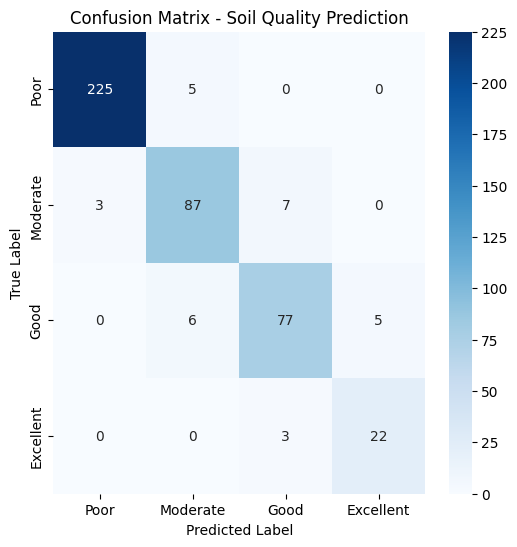

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_reg_pred, y_clf_pred = model.predict(X_test_scaled)

y_clf_pred_classes = np.argmax(y_clf_pred, axis=1)

cm = confusion_matrix(y_clf_test, y_clf_pred_classes)

print("Confusion Matrix:\n", cm)

class_names = ["Poor", "Moderate", "Good", "Excellent"]

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Soil Quality Prediction")
plt.show()


Mean Squared Error (MSE): 0.20
Mean Absolute Error (MAE): 0.32
R² Score: 0.84


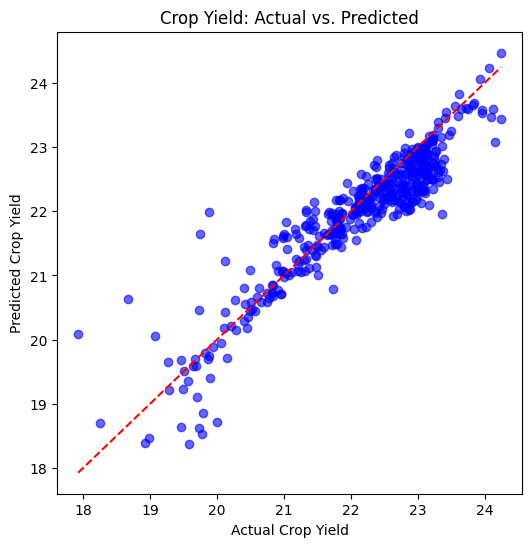

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_reg_pred_rescaled = scaler_y.inverse_transform(y_reg_pred.reshape(-1, 1)) 
y_reg_test_rescaled = scaler_y.inverse_transform(y_reg_test_scaled.reshape(-1, 1))

mse = mean_squared_error(y_reg_test_rescaled, y_reg_pred_rescaled)
mae = mean_absolute_error(y_reg_test_rescaled, y_reg_pred_rescaled)
r2 = r2_score(y_reg_test_rescaled, y_reg_pred_rescaled)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_reg_test_rescaled, y_reg_pred_rescaled, alpha=0.6, color="blue")
plt.plot([min(y_reg_test_rescaled), max(y_reg_test_rescaled)], [min(y_reg_test_rescaled), max(y_reg_test_rescaled)], color="red", linestyle="--")
plt.xlabel("Actual Crop Yield")
plt.ylabel("Predicted Crop Yield")
plt.title("Crop Yield: Actual vs. Predicted")
plt.show()


In [79]:
from sklearn.metrics import r2_score

r2 = r2_score(y_reg_test_rescaled, y_reg_pred_rescaled)
print(f"R² Score: {r2:.3f}") 
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_reg_test_rescaled, y_reg_pred_rescaled)
mae = mean_absolute_error(y_reg_test_rescaled, y_reg_pred_rescaled)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


R² Score: 0.839
Mean Squared Error (MSE): 0.20
Mean Absolute Error (MAE): 0.32


In [81]:
y_reg_pred_scaled , y_clf_pred = model.predict(X_test_scaled)
y_reg_pred_actual = scaler_y.inverse_transform(y_reg_pred_scaled)
y_clf_pred_labels = np.argmax(y_clf_pred, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [83]:
test_loss, test_reg_loss, test_clf_loss, test_mse, test_accuracy = model.evaluate(X_test_scaled, [y_reg_test_scaled, y_clf_test])
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_3_loss: 0.1418 - dense_3_mse: 0.1417 - dense_4_accuracy: 0.9253 - dense_4_loss: 0.1918 - loss: 0.9881 
Test Loss: 0.9857, Test Accuracy: 0.9341


In [85]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [87]:
model.save("final_agriculture_model.keras")

In [105]:
'''''''''''''''''''''''''''
A WINDOW FOR MODEL PREDICTION,
PREDICT YOUR OWN DATASET!!
'''''''''''''''''''''''''''
from tkinter import messagebox
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import os, tkinter as tk
from tkinter import*
from PIL import Image, ImageTk
from pygame import mixer

In [107]:
model = tf.keras.models.load_model("final_agriculture_model.keras")

In [109]:
scaler = joblib.load('scaler.pkl')
scaler_y = joblib.load('scaler_y.pkl')

In [111]:
root = tk.Tk()
root.title('Agriculture, Soil Quality and Crop Yield Prediction')


def rgb_to_hex(r, g, b):
    return f'#{r:02X}{g:02X}{b:02X}'

r, g, b = 255, 0, 0
direction = 1
BG_COLOR = rgb_to_hex(r, g, b)

def update_bg():
    global r, g, b, direction, BG_COLOR
    
    if direction == 1:
        r -= 5
        g += 5
        if g >= 255:  
            direction = 2
    elif direction == 2:
        g -= 5
        b += 5
        if b >= 255: 
            direction = 3
    elif direction == 3:
        b -= 5
        r += 5
        if r >= 255:  
            direction = 1

    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
         

    BG_COLOR = rgb_to_hex(r, g, b)

    root.configure(bg=BG_COLOR)
    for widget in root.winfo_children():
        if isinstance(widget, tk.Button) and widget.cget("text") == "Predict":
            continue  
        if isinstance(widget, tk.Label) and widget.cget("text") == "Which type of crop are you growing?:":  
            continue 
        try:
            widget.configure(bg=BG_COLOR)
        except:
            pass

    root.after(100, update_bg)

In [113]:
tk.Label(root, text="Nitrogen (N)").grid(row=0, column=0)
entry_N = tk.Entry(root)
entry_N.grid(row=0, column=1)

tk.Label(root, text="Phosphorus (P)").grid(row=1, column=0)
entry_P = tk.Entry(root)
entry_P.grid(row=1, column=1)

tk.Label(root, text="Potassium (K)").grid(row=2, column=0)
entry_K = tk.Entry(root)
entry_K.grid(row=2, column=1)

tk.Label(root, text="Temperature").grid(row=3, column=0)
entry_temp = tk.Entry(root)
entry_temp.grid(row=3, column=1)

tk.Label(root, text="Humidity").grid(row=4, column=0)
entry_humidity = tk.Entry(root)
entry_humidity.grid(row=4, column=1)

tk.Label(root, text="pH Level").grid(row=5, column=0)
entry_ph = tk.Entry(root)
entry_ph.grid(row=5, column=1)

tk.Label(root, text="NPK Ratio").grid(row=6, column=0)
entry_NPK_ratio = tk.Entry(root)
entry_NPK_ratio.grid(row=6, column=1)

tk.Label(root, text="Rainfall").grid(row=7, column=0)
entry_rainfall = tk.Entry(root)
entry_rainfall.grid(row=7, column=1)

tk.Label(root, text="Wind Speed").grid(row=8, column=0)
entry_wind = tk.Entry(root)
entry_wind.grid(row=8, column=1)

tk.Label(root, text="Solar Radiation").grid(row=9, column=0)
entry_solar = tk.Entry(root)
entry_solar.grid(row=9, column=1)



soil_quality_labels = {
    0: "Poor",
    1: "Moderate",
    2: "Good",
    3: "Excellent"
}

crop_categories = [
    'Crop Variety Category_banana', 'Crop Variety Category_blackgram',
       'Crop Variety Category_chickpea', 'Crop Variety Category_coconut',
       'Crop Variety Category_coffee', 'Crop Variety Category_cotton',
       'Crop Variety Category_grapes', 'Crop Variety Category_jute',
       'Crop Variety Category_kidneybeans', 'Crop Variety Category_lentil',
       'Crop Variety Category_maize', 'Crop Variety Category_mango',
       'Crop Variety Category_mothbeans', 'Crop Variety Category_mungbean',
       'Crop Variety Category_muskmelon', 'Crop Variety Category_orange',
       'Crop Variety Category_papaya', 'Crop Variety Category_pigeonpeas',
       'Crop Variety Category_pomegranate', 'Crop Variety Category_rice',
       'Crop Variety Category_watermelon'
]
display_crop_names = [crop.replace("Crop Variety Category_", "") for crop in crop_categories]

selected_crop = tk.StringVar(value=display_crop_names[0])
tk.Label(root, text="Which type of crop are you growing?:",bg="#3A8DFF", font=("Tahoma", 12, "bold")).grid(row=12, column=0, columnspan=2)
for i, crop in enumerate(display_crop_names):
    tk.Radiobutton(root, text=crop, variable=selected_crop, value=crop, highlightthickness=0, bg = root.cget('bg'), bd = 0 , fg="black", font=("Helvetica", 12, "bold"),
                           relief="flat", padx=20, pady=10).grid(row=14 + i // 2, column=i % 2)

In [115]:
fields = ['N', 'P' ,'K' ,'temperature' ,'humidity' ,'ph', 'NPK_Ratio' ,'rainfall',
 'Wind_Speed (m/s)', 'Solar_Radiation (kWh/m²)']

def predict():
    try:
        inputs = [
            float(entry_N.get()),     
            float(entry_P.get()),
            float(entry_K.get()),
            float(entry_temp.get()),
            float(entry_humidity.get()),
            float(entry_ph.get()),
            float(entry_NPK_ratio.get()),
            float(entry_rainfall.get()),
            float(entry_wind.get()),
            float(entry_solar.get())
        ] 

        crop_inputs = [0] * len(crop_categories)
        selected_full_name = f"Crop Variety Category_{selected_crop.get()}"

        if selected_full_name in crop_categories:
           crop_index = crop_categories.index(selected_full_name)
           crop_inputs[crop_index] = 1
        else:
           print("Warning: Selected crop not found in categories!")
           return  

        final_inputs = np.array(inputs + crop_inputs).reshape(1, -1)

        feature_names = fields + crop_categories
        final_inputs_df = pd.DataFrame(final_inputs, columns=feature_names)

        final_inputs_df = final_inputs_df[scaler.feature_names_in_]

        print("Scaler expected features:", scaler.feature_names_in_)
        print("Your input feature names:", list(final_inputs_df.columns))
        print("Final Inputs DataFrame:\n", final_inputs_df)
 
        try:
            inputs_scaled = scaler.transform(final_inputs_df)
            if np.isnan(inputs_scaled).any():
                print("Error: NaN values detected after scaling!")
                return
            print("Inputs Scaled:", inputs_scaled)
        except Exception as e:
            print("Scaling Error:", e)
            return
 
        inputs_scaled = np.asarray(inputs_scaled, dtype=np.float32)

        y_reg_pred, y_clf_pred = model.predict(inputs_scaled)
        print("Raw Regression Output:", y_reg_pred)
        
        y_reg_pred = np.array(y_reg_pred).reshape(-1, 1)
        y_reg_pred_rescaled = scaler_y.inverse_transform(y_reg_pred)[0][0]

        y_reg_pred_rescaled = max(0, y_reg_pred_rescaled) 

        soil_quality_index = np.argmax(y_clf_pred, axis=1)[0]
        soil_quality_text = soil_quality_labels.get(soil_quality_index, "Unknown")

        messagebox.showinfo("Prediction", f"Crop Yield: {y_reg_pred_rescaled:.2f}\nSoil Quality: {soil_quality_text}")

    except Exception as e:
        messagebox.showerror("Error", str(e))

    print("Scaler Mean:", scaler_y.mean_)
    print("Scaler Scale:", scaler_y.scale_)
    print("Mean:", scaler.mean_)
    print("Scale:", scaler.scale_)
    print("Min (approx):", scaler.mean_ - scaler.scale_)
    print("Max (approx):", scaler.mean_ + scaler.scale_)

In [117]:
def music_start():
    mixer.init()
    mixer.music.load(r"F:\ML_Project_Agri\Sigma - 1.mp3")
    mixer.music.play(-1)
def music_stop():
    mixer.music.stop()
    if root.winfo_exists():
      root.destroy()

In [119]:
tk.Button(root, text = 'Predict' , command = predict,  bg="#4CAF50", fg="white", font=("Helvetica", 12, "bold"), relief="flat", padx=20, pady=10).grid(row = 25 , columnspan = 2, pady = 10)
update_bg()
music_start()
root.protocol("WM_DELETE_WINDOW", music_stop)
root.mainloop()

Scaler expected features: ['N' 'P' 'K' 'temperature' 'humidity' 'ph' 'NPK_Ratio' 'rainfall'
 'Wind_Speed (m/s)' 'Solar_Radiation (kWh/m²)'
 'Crop Variety Category_banana' 'Crop Variety Category_blackgram'
 'Crop Variety Category_chickpea' 'Crop Variety Category_coconut'
 'Crop Variety Category_coffee' 'Crop Variety Category_cotton'
 'Crop Variety Category_grapes' 'Crop Variety Category_jute'
 'Crop Variety Category_kidneybeans' 'Crop Variety Category_lentil'
 'Crop Variety Category_maize' 'Crop Variety Category_mango'
 'Crop Variety Category_mothbeans' 'Crop Variety Category_mungbean'
 'Crop Variety Category_muskmelon' 'Crop Variety Category_orange'
 'Crop Variety Category_papaya' 'Crop Variety Category_pigeonpeas'
 'Crop Variety Category_pomegranate' 'Crop Variety Category_rice'
 'Crop Variety Category_watermelon']
Your input feature names: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'NPK_Ratio', 'rainfall', 'Wind_Speed (m/s)', 'Solar_Radiation (kWh/m²)', 'Crop Variety Category_b